In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from scipy.stats import multivariate_normal
from scipy.stats import ortho_group
from scipy import fft
import copy 

In [2]:
# utility function to generate random non singular covariance matrices with 
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        Q = ortho_group.rvs(d)
        eps = 1e-5
        U = np.random.rand(d)*2.5 + eps
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return ans

In [3]:
# gmm recovery from a synthetic gmm
# make a representative gmm
def make_gmm(n_components, n_features, random_state=0):
    gmm = GaussianMixture(n_components=n_components)
    gmm.means_ = np.random.rand(n_components, n_features) * 10
    covariance_array = generate_covariance_matrices(n_components, n_features)
    # for i in range(n_components):
    #     rand_matrix = np.random.rand(n_features, n_features)
    #     covariance_array.append(np.dot(rand_matrix, rand_matrix.T))

    gmm.covariances_ = np.array(covariance_array)

    precision_array = [np.linalg.pinv(cov) for cov in covariance_array]
    gmm.precisions_ = np.array(precision_array)
    gmm.precisions_cholesky_ = np.array([np.linalg.cholesky(prec) for prec in precision_array])
    
    gmm.weights_ = np.random.rand(n_components)
    gmm.weights_ /= np.sum(gmm.weights_)
    return gmm

In [4]:
n_components = 5
n_features = 2

oracle_gmm = make_gmm(n_components, n_features)

n_samples = 10000
X = oracle_gmm.sample(n_samples=n_samples)[0]
X_train, X_val = X[:n_samples-1500], X[n_samples-1500:]

In [5]:
# estimate the gmm
estimated_gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=10, verbose=1)
estimated_gmm.fit(X_train)

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
Initialization 5
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
Initialization converged: True
Initialization 8
Initialization converged: True
Initialization 9
Initialization converged: True


GaussianMixture(n_components=5, n_init=10, verbose=1)

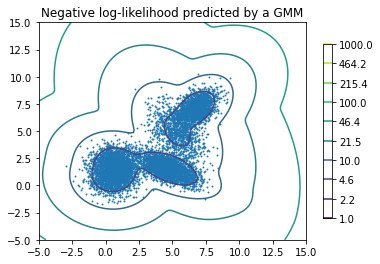

In [6]:
# The following code is useful for visualizing the gmm when the number of features is 2
from matplotlib.colors import LogNorm

# plot the estimated gmm
x = np.linspace(-5, 15, 100)
y = np.linspace(-5, 15, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = -estimated_gmm.score_samples(XX)
Z = Z.reshape(X_grid.shape)
CS = plt.contour(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                    levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


In [7]:
# estimate the entropy of the gmm
def estimate_entropy_by_samples(gmm, n_samples=10000):
    X_sampled = gmm.sample(n_samples=n_samples)[0]
    log_likelihoods = gmm.score_samples(X_sampled)
    return -np.mean(log_likelihoods)

def estimate_entropy_by_data(gmm, X):
    log_likelihoods = gmm.score_samples(X)
    return -np.mean(log_likelihoods)

# estimate the entropy of the oracle gmm
oracle_entropy_sample = estimate_entropy_by_samples(oracle_gmm)
oracle_entropy_data = estimate_entropy_by_data(oracle_gmm, X)
print("oracle entropy sample: ", oracle_entropy_sample)
print("oracle entropy data: ", oracle_entropy_data)
# estimate the entropy of the estimated gmm
estimated_entropy_sample = estimate_entropy_by_samples(estimated_gmm)
estimated_entropy_data = estimate_entropy_by_data(estimated_gmm, X_train)
print("estimated entropy sample: ", estimated_entropy_sample)
print("estimated entropy data: ", estimated_entropy_data)

oracle entropy sample:  3.8225816429486685
oracle entropy data:  3.8016161027561495
estimated entropy sample:  3.7410399015424054
estimated entropy data:  3.7377912135745683


In [8]:
estimated_entropy = estimated_entropy_data

anomalous_data_length = [pow(2, i) for i in range(1, 11)]
epsilon_m = []
confidence = 0.9
K = 1000
for m in anomalous_data_length:
    # using bootstrap method to calculate epsilon with 90% confidence interval for each m
    vals = []
    for _ in range(K):
        # use X_val and bootstrap m samples from it
        sample_set = resample(X_val, n_samples=m)
        # calculate the entropy of the sample set
        sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
        vals.append(abs(sample_entropy - estimated_entropy))
    vals.sort()
    # print(vals)
    epsilon_m.append(vals[int(K * confidence)])

print(epsilon_m)

[2.222715712146619, 1.7920836561302051, 1.5049778376999008, 1.2787868534973326, 1.079532587959247, 0.9660153615280711, 0.8699595287462234, 0.8085188260944305, 0.7700916465915286, 0.7355098665792772]


type-1 error for m=2: 1.7 %
type-1 error for m=4: 1.4 %
type-1 error for m=8: 0.6 %
type-1 error for m=16: 0.1 %
type-1 error for m=32: 0.0 %
type-1 error for m=64: 0.0 %
type-1 error for m=128: 0.0 %
type-1 error for m=256: 0.0 %
type-1 error for m=512: 0.0 %
type-1 error for m=1024: 0.0 %


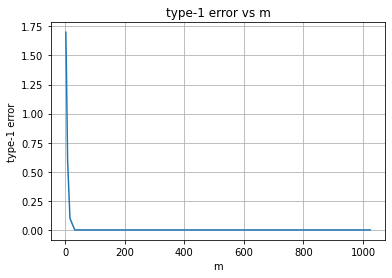

In [9]:
# type-1 error calculation
error_wrt_m = []
for m in anomalous_data_length:
    errors = 0
    for _ in range(K):
        sample_set = oracle_gmm.sample(n_samples=m)[0]
        sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
        if abs(sample_entropy - estimated_entropy) > epsilon_m[int(np.log2(m))-1]:
            errors += 1
    print(f"type-1 error for m={m}: {errors*100/K} %")
    error_wrt_m.append(errors*100/K)

plt.figure()
plt.plot(anomalous_data_length, error_wrt_m)
plt.grid()
plt.xlabel("m")
plt.ylabel("type-1 error")
plt.title("type-1 error vs m")
plt.show()

-------------- shift count: 1 --------------


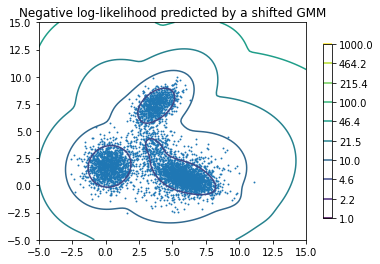

type-2 error for m=2: 76.7 %
type-2 error for m=4: 72.5 %
type-2 error for m=8: 67.6 %
type-2 error for m=16: 54.2 %
type-2 error for m=32: 33.4 %
type-2 error for m=64: 13.1 %
type-2 error for m=128: 2.2 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 2 --------------


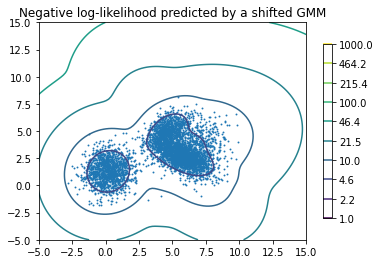

type-2 error for m=2: 87.5 %
type-2 error for m=4: 85.0 %
type-2 error for m=8: 82.2 %
type-2 error for m=16: 72.6 %
type-2 error for m=32: 47.3 %
type-2 error for m=64: 21.3 %
type-2 error for m=128: 2.3 %
type-2 error for m=256: 0.1 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 3 --------------


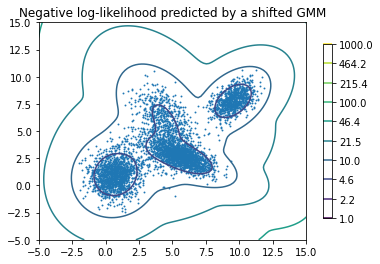

type-2 error for m=2: 62.5 %
type-2 error for m=4: 47.5 %
type-2 error for m=8: 29.1 %
type-2 error for m=16: 12.4 %
type-2 error for m=32: 1.7 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 4 --------------


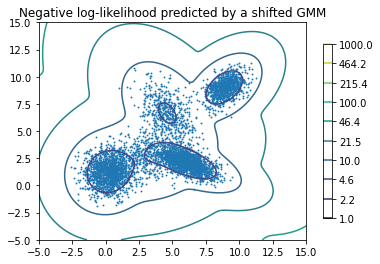

type-2 error for m=2: 70.9 %
type-2 error for m=4: 59.8 %
type-2 error for m=8: 47.9 %
type-2 error for m=16: 27.3 %
type-2 error for m=32: 6.0 %
type-2 error for m=64: 0.4 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 5 --------------


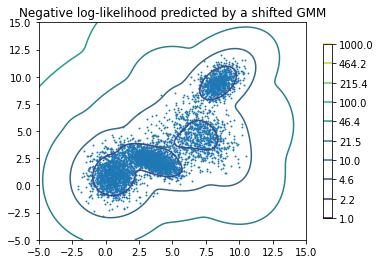

type-2 error for m=2: 74.1 %
type-2 error for m=4: 68.6 %
type-2 error for m=8: 59.0 %
type-2 error for m=16: 45.3 %
type-2 error for m=32: 24.7 %
type-2 error for m=64: 7.2 %
type-2 error for m=128: 0.5 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 6 --------------


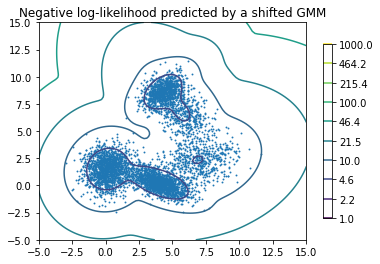

type-2 error for m=2: 53.6 %
type-2 error for m=4: 37.1 %
type-2 error for m=8: 21.3 %
type-2 error for m=16: 4.7 %
type-2 error for m=32: 0.0 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 7 --------------


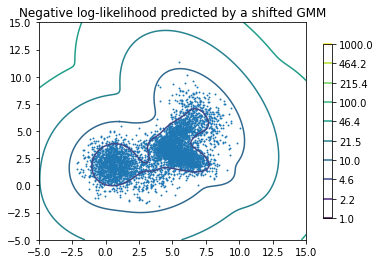

type-2 error for m=2: 92.6 %
type-2 error for m=4: 87.9 %
type-2 error for m=8: 86.9 %
type-2 error for m=16: 83.0 %
type-2 error for m=32: 72.8 %
type-2 error for m=64: 61.7 %
type-2 error for m=128: 33.9 %
type-2 error for m=256: 9.7 %
type-2 error for m=512: 0.2 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 8 --------------


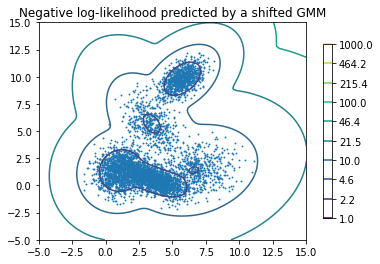

type-2 error for m=2: 50.1 %
type-2 error for m=4: 33.9 %
type-2 error for m=8: 16.0 %
type-2 error for m=16: 3.2 %
type-2 error for m=32: 0.0 %
type-2 error for m=64: 0.0 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 9 --------------


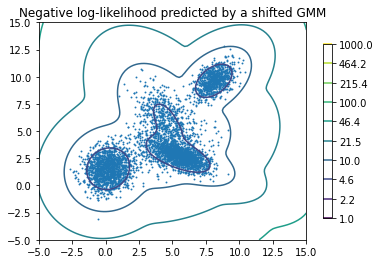

type-2 error for m=2: 74.8 %
type-2 error for m=4: 57.4 %
type-2 error for m=8: 43.0 %
type-2 error for m=16: 23.4 %
type-2 error for m=32: 4.5 %
type-2 error for m=64: 0.1 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %
-------------- shift count: 10 --------------


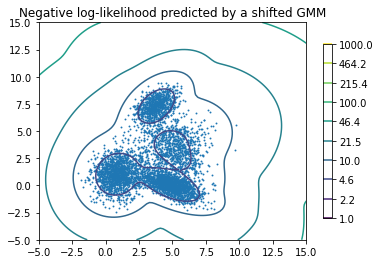

type-2 error for m=2: 68.2 %
type-2 error for m=4: 55.1 %
type-2 error for m=8: 41.6 %
type-2 error for m=16: 20.9 %
type-2 error for m=32: 4.0 %
type-2 error for m=64: 0.1 %
type-2 error for m=128: 0.0 %
type-2 error for m=256: 0.0 %
type-2 error for m=512: 0.0 %
type-2 error for m=1024: 0.0 %


In [10]:
# building an anomalous data set to test the type-2 error
def get_random_unit_vector(n):
    v = np.random.normal(size=n)
    return v/np.linalg.norm(v)

# utility function to shift gmm
def shift_gmm(original_gmm, fc):
    # shift means randomly by fc% of its norm and copy everything else as is
    for i in range(n_components):
        original_gmm.means_[i] = original_gmm.means_[i] + (fc * np.linalg.norm(original_gmm.means_[i]) * get_random_unit_vector(n_features))
        original_gmm.covariances_[i] = original_gmm.covariances_[i]
        original_gmm.precisions_[i] = original_gmm.precisions_[i]
        original_gmm.precisions_cholesky_[i] = original_gmm.precisions_cholesky_[i]
        original_gmm.weights_ = original_gmm.weights_

    return original_gmm

def mean_type_2_error(oracle_gmm, estimated_gmm, epsilon_m, K, deviation_factor):
    # type-2 error calculation
    error_wrt_m_mean = np.zeros(len(anomalous_data_length))

    for shf_cnt in range(10):
        print(f"-------------- shift count: {shf_cnt+1} --------------")
        error_wrt_m = np.zeros(len(anomalous_data_length))
        shifted_gmm = copy.deepcopy(oracle_gmm)
        shifted_gmm = shift_gmm(shifted_gmm, deviation_factor)

        shifted_samples = shifted_gmm.sample(n_samples=5000)[0]
        # plot the shifted gmm
        if(shf_cnt < 10):
            plt.figure(shf_cnt+1)
            x = np.linspace(-5, 15, 100)
            y = np.linspace(-5, 15, 100)
            X_grid, Y_grid = np.meshgrid(x, y)
            XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
            Z = -shifted_gmm.score_samples(XX)
            Z = Z.reshape(X_grid.shape)
            CS = plt.contour(X_grid, Y_grid, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                                levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(shifted_samples[:, 0], shifted_samples[:, 1], .8)
            plt.title('Negative log-likelihood predicted by a shifted GMM')
            plt.axis('tight')
            plt.show()

        for m in anomalous_data_length:
            # type-2 error calculation
            errors = 0
            for _ in range(K):
                sample_set = shifted_gmm.sample(n_samples=m)[0]
                sample_entropy = estimate_entropy_by_data(estimated_gmm, sample_set)
                if abs(sample_entropy - estimated_entropy) <= epsilon_m[int(np.log2(m))-1]:
                    errors += 1
            error_wrt_m[int(np.log2(m))-1] = errors*100/K
            print(f"type-2 error for m={m}: {errors*100/K} %")
        error_wrt_m_mean += error_wrt_m

    error_wrt_m_mean = error_wrt_m_mean/10
    return error_wrt_m_mean

avg_error_wrt_m = mean_type_2_error(oracle_gmm, estimated_gmm, epsilon_m, K, 0.3)
